In [1]:
# ================================================================
# 1: Import Libraries
# ================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    roc_auc_score,
    roc_curve
)
from sklearn.model_selection import cross_val_score, GridSearchCV
import warnings
warnings.filterwarnings('ignore')
import time

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('default')
sns.set_palette(["#1f4e79"])   # a strong, navy‑blue

print("📚 Libraries imported successfully!")

📚 Libraries imported successfully!


In [2]:
# ================================================================
# 2. LOAD SAVED DATA
# ================================================================
print("📂 Loading saved training and test data...")
print("=" * 50)

try:
    # Load features
    X_train_lgb = pd.read_csv('../Data/output/X_train_encoded.csv')
    X_test_lgb = pd.read_csv('../Data/output/X_test_encoded.csv')
    
    # Load labels
    y_train_lgb = pd.read_csv('../Data/output/y_train.csv').squeeze()  # squeeze() converts DataFrame to Series
    y_test_lgb = pd.read_csv('../Data/output/y_test.csv').squeeze()
    
    print("✅ Data loaded successfully!")
    print(f"   Training features: {X_train_lgb.shape}")
    print(f"   Test features: {X_test_lgb.shape}")
    print(f"   Training labels: {y_train_lgb.shape}")
    print(f"   Test labels: {y_test_lgb.shape}")
    
except FileNotFoundError as e:
    print(f"❌ Error: Could not find data files. {e}")
    print("Make sure you've run the encoding notebook first!")
except Exception as e:
    print(f"❌ Error loading data: {e}")

📂 Loading saved training and test data...
✅ Data loaded successfully!
   Training features: (22180, 20)
   Test features: (5545, 20)
   Training labels: (22180,)
   Test labels: (5545,)


In [3]:
# ================================================================
# 3. ANALYZE CLASS DISTRIBUTION (DETERMINES BEST SCORING METRIC)
# ================================================================

print("📊 ANALYZING CLASS DISTRIBUTION")
print("=" * 50)

# Check target variable distribution using your training data
class_counts = pd.Series(y_train_lgb).value_counts().sort_index()
class_percentages = pd.Series(y_train_lgb).value_counts(normalize=True).sort_index() * 100

print("Class distribution in training data:")
for class_label, count in class_counts.items():
    percentage = class_percentages[class_label]
    print(f"  Class {class_label}: {count:,} samples ({percentage:.1f}%)")

# Calculate imbalance ratio
max_class_count = class_counts.max()
min_class_count = class_counts.min()
imbalance_ratio = max_class_count / min_class_count

print(f"\n📈 Imbalance Analysis:")
print(f"  Largest class: {max_class_count:,} samples")
print(f"  Smallest class: {min_class_count:,} samples")
print(f"  Imbalance ratio: {imbalance_ratio:.2f}:1")

# Determine best scoring metric
if imbalance_ratio > 2.0:
    print("⚠️  Dataset appears imbalanced - F1-weighted recommended")
    recommended_scoring = 'f1_weighted'
    scoring_explanation = "F1-weighted handles class imbalance better than accuracy"
else:
    print("✅ Dataset appears balanced - accuracy is acceptable")
    recommended_scoring = 'accuracy'
    scoring_explanation = "Accuracy is reliable for balanced datasets"

print(f"🎯 Recommended scoring: {recommended_scoring}")
print(f"💡 Why: {scoring_explanation}")

📊 ANALYZING CLASS DISTRIBUTION
Class distribution in training data:
  Class 0: 4,237 samples (19.1%)
  Class 1: 5,634 samples (25.4%)
  Class 2: 12,309 samples (55.5%)

📈 Imbalance Analysis:
  Largest class: 12,309 samples
  Smallest class: 4,237 samples
  Imbalance ratio: 2.91:1
⚠️  Dataset appears imbalanced - F1-weighted recommended
🎯 Recommended scoring: f1_weighted
💡 Why: F1-weighted handles class imbalance better than accuracy


In [30]:
# ================================================================
# 4. DEFINE PARAMETER GRIDS (CHOOSE YOUR SPEED VS THOROUGHNESS)
# ================================================================

print(f"\n🔧 PARAMETER GRID OPTIONS")
print("=" * 50)

# Option 1: FAST Grid (20-30 minutes)
fast_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [6, 8, 10],
    'learning_rate': [0.1, 0.05],
    'num_leaves': [31, 50, 100],
    'min_child_samples': [20, 30],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'class_weight': ['balanced', None]
}

# Option 2: COMPREHENSIVE Grid (1-2 hours)
comprehensive_param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [6, 8, 10, 12, -1],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'num_leaves': [31, 50, 100, 150],
    'min_child_samples': [10, 20, 30, 50],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5],
    'class_weight': ['balanced', None]
}

# Option 3: SMART Grid (30-60 minutes) - RECOMMENDED
smart_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [6, 8, 10, -1],
    'learning_rate': [0.05, 0.1, 0.15],
    'num_leaves': [31, 50, 100],
    'min_child_samples': [20, 30, 50],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.1],
    'class_weight': ['balanced', None]
}

# Choose which grid to use (CHANGE THIS IF YOU WANT DIFFERENT SPEED)
#chosen_param_grid = smart_param_grid  # RECOMMENDED
#grid_name = "SMART"
chosen_param_grid = fast_param_grid
grid_name = "FAST"

# Calculate combinations
total_combinations = np.prod([len(v) for v in chosen_param_grid.values()])
print(f"🎯 Using {grid_name} parameter grid")
print(f"📊 Total combinations to test: {total_combinations}")

if grid_name == "FAST":
    print("⏱️  Estimated time: 90-120 minutes")
elif grid_name == "SMART":
    print("⏱️  Estimated time: 120-180 minutes")
else:
    print("⏱️  Estimated time: 3-5 hours")


🔧 PARAMETER GRID OPTIONS
🎯 Using FAST parameter grid
📊 Total combinations to test: 864
⏱️  Estimated time: 90-120 minutes


In [5]:
# ================================================================
# 5. SETUP MULTI-SCORING GRIDSEARCHCV
# ================================================================

print(f"\n🎯 GRIDSEARCHCV CONFIGURATION")
print("=" * 50)

# Define multiple scoring metrics
scoring_metrics = {
    'accuracy': 'accuracy',
    'f1_weighted': 'f1_weighted',
    'f1_macro': 'f1_macro',
    'precision_weighted': 'precision_weighted',
    'recall_weighted': 'recall_weighted'
}

cv_folds = 5
print(f"🎯 Primary scoring metric: {recommended_scoring}")
print(f"📊 Additional metrics tracked: {list(scoring_metrics.keys())}")
print(f"🔄 Cross-validation folds: {cv_folds}")
print(f"💻 Parallel processing: Enabled (n_jobs=-1)")

# Configure GridSearchCV
grid_search = GridSearchCV(
    estimator=lgb.LGBMClassifier(
        random_state=42,
        n_jobs=-1,
        verbose=-1,  # Suppress LightGBM warnings
        force_col_wise=True  # Avoid potential issues with column-wise training
    ),
    param_grid=chosen_param_grid,
    scoring=scoring_metrics,
    refit=recommended_scoring,  # Refit using the best metric for your data
    cv=cv_folds,               # n-fold CV for reasonable speed
    n_jobs=-1,                 # Use all CPU cores
    verbose=2,                 # Show detailed progress
    return_train_score=True    # Track overfitting
)


🎯 GRIDSEARCHCV CONFIGURATION
🎯 Primary scoring metric: f1_weighted
📊 Additional metrics tracked: ['accuracy', 'f1_weighted', 'f1_macro', 'precision_weighted', 'recall_weighted']
🔄 Cross-validation folds: 5
💻 Parallel processing: Enabled (n_jobs=-1)


In [6]:
# ================================================================
# 6. RUN GRIDSEARCHCV
# ================================================================

print(f"\n🚀 STARTING GRIDSEARCHCV...")
print("=" * 50)
print("📝 This will show detailed progress. Please wait...")

start_time = time.time()

# Fit GridSearchCV using your training data
grid_search.fit(X_train_lgb, y_train_lgb)

total_time = time.time() - start_time
print(f"\n✅ GridSearchCV COMPLETED!")
print(f"⏱️  Total runtime: {total_time:.1f} seconds ({total_time/60:.1f} minutes)")


🚀 STARTING GRIDSEARCHCV...
📝 This will show detailed progress. Please wait...
Fitting 5 folds for each of 864 candidates, totalling 4320 fits

✅ GridSearchCV COMPLETED!
⏱️  Total runtime: 6520.0 seconds (108.7 minutes)


In [16]:
# ================================================================
# 7. EXTRACT AND DISPLAY RESULTS
# ================================================================

print(f"\n🏆 GRIDSEARCHCV RESULTS")
print("=" * 60)

# Display best parameters
print(f"🎯 BEST PARAMETERS (optimized for {recommended_scoring}):")
for param, value in grid_search.best_params_.items():
    print(f"   {param:20s}: {value}")

# Display best cross-validation scores for all metrics
print(f"\n📊 BEST CROSS-VALIDATION SCORES:")
cv_results = grid_search.cv_results_
best_index = grid_search.best_index_

for metric_name, metric_key in scoring_metrics.items():
    score_key = f'mean_test_{metric_name}'
    std_key = f'std_test_{metric_name}'
    
    if score_key in cv_results:
        mean_score = cv_results[score_key][best_index]
        std_score = cv_results[std_key][best_index]
        print(f"   {metric_name:20s}: {mean_score:.4f} ± {std_score:.4f}")


🏆 GRIDSEARCHCV RESULTS
🎯 BEST PARAMETERS (optimized for f1_weighted):
   class_weight        : balanced
   colsample_bytree    : 1.0
   learning_rate       : 0.05
   max_depth           : 10
   min_child_samples   : 20
   n_estimators        : 100
   num_leaves          : 31
   subsample           : 0.8

📊 BEST CROSS-VALIDATION SCORES:
   accuracy            : 0.5466 ± 0.0042
   f1_weighted         : 0.5509 ± 0.0056
   f1_macro            : 0.4664 ± 0.0079
   precision_weighted  : 0.5561 ± 0.0080
   recall_weighted     : 0.5466 ± 0.0042


In [8]:
# ================================================================
# 8. EVALUATE BEST MODEL ON TEST SET
# ================================================================

print(f"\n🔮 FINAL MODEL EVALUATION ON TEST SET")
print("=" * 60)

# Get the best model (already trained)
best_lgb_model = grid_search.best_estimator_

# Make predictions on your test set
print("📊 Making predictions on test set...")
y_pred_test = best_lgb_model.predict(X_test_lgb)

# Calculate test set metrics
test_accuracy = accuracy_score(y_test_lgb, y_pred_test)
test_f1_weighted = f1_score(y_test_lgb, y_pred_test, average='weighted')
test_f1_macro = f1_score(y_test_lgb, y_pred_test, average='macro')

print(f"\n📈 TEST SET PERFORMANCE:")
print(f"   Accuracy:     {test_accuracy:.4f}")
print(f"   F1-Weighted:  {test_f1_weighted:.4f}")
print(f"   F1-Macro:     {test_f1_macro:.4f}")


🔮 FINAL MODEL EVALUATION ON TEST SET
📊 Making predictions on test set...

📈 TEST SET PERFORMANCE:
   Accuracy:     0.5416
   F1-Weighted:  0.5470
   F1-Macro:     0.4658


In [9]:
# ================================================================
# 9. DETAILED CLASSIFICATION REPORT
# ================================================================

print(f"\n📋 DETAILED CLASSIFICATION REPORT:")
print("=" * 60)
print(classification_report(y_test_lgb, y_pred_test))


📋 DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.29      0.34      0.31      1059
           1       0.38      0.38      0.38      1410
           2       0.72      0.69      0.70      3076

    accuracy                           0.54      5545
   macro avg       0.47      0.47      0.47      5545
weighted avg       0.55      0.54      0.55      5545




📊 CREATING CONFUSION MATRIX...

📋 CONFUSION MATRIX (Plain Text):
Predicted    0    1     2
Actual                   
0          356  348   355
1          417  536   457
2          450  515  2111


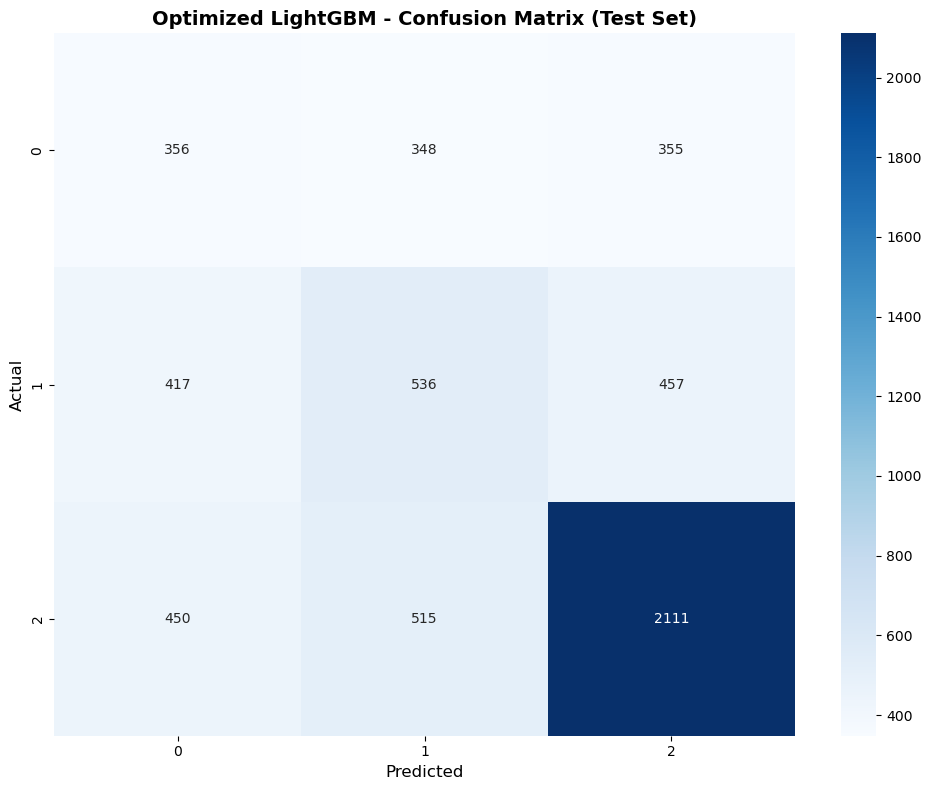

In [10]:
# ================================================================
# 10. CONFUSION MATRIX VISUALIZATION
# ================================================================

print(f"\n📊 CREATING CONFUSION MATRIX...")

# Calculate confusion matrix
cm = confusion_matrix(y_test_lgb, y_pred_test)

# Get unique class labels
class_labels = sorted(np.unique(y_train_lgb))

# Create plain-text confusion matrix table
print(f"\n📋 CONFUSION MATRIX (Plain Text):")
print("=" * 50)
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)
cm_df.index.name = 'Actual'
cm_df.columns.name = 'Predicted'
print(cm_df)
print("=" * 50)

# Create confusion matrix plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Optimized LightGBM - Confusion Matrix (Test Set)', fontsize=14, fontweight='bold')
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.tight_layout()
plt.show()

In [11]:
# ================================================================
# 11. TOP PARAMETER COMBINATIONS ANALYSIS
# ================================================================

print(f"\n🔍 TOP 5 PARAMETER COMBINATIONS")
print("=" * 60)

# Convert results to DataFrame for analysis
results_df = pd.DataFrame(grid_search.cv_results_)
primary_score_col = f'mean_test_{recommended_scoring}'

# Get top 5 combinations
top_5_results = results_df.nlargest(5, primary_score_col)

print(f"🏆 Top 5 combinations (ranked by {recommended_scoring}):")
print("-" * 80)

for i, (idx, row) in enumerate(top_5_results.iterrows(), 1):
    score = row[primary_score_col]
    std_score = row[f'std_test_{recommended_scoring}']
    params = row['params']
    
    print(f"{i}. Score: {score:.4f} ± {std_score:.4f}")
    print(f"   Parameters: {params}")
    print()


🔍 TOP 5 PARAMETER COMBINATIONS
🏆 Top 5 combinations (ranked by f1_weighted):
--------------------------------------------------------------------------------
1. Score: 0.5509 ± 0.0056
   Parameters: {'class_weight': 'balanced', 'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 10, 'min_child_samples': 20, 'n_estimators': 100, 'num_leaves': 31, 'subsample': 0.8}

2. Score: 0.5509 ± 0.0056
   Parameters: {'class_weight': 'balanced', 'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 10, 'min_child_samples': 20, 'n_estimators': 100, 'num_leaves': 31, 'subsample': 1.0}

3. Score: 0.5508 ± 0.0076
   Parameters: {'class_weight': 'balanced', 'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_samples': 20, 'n_estimators': 100, 'num_leaves': 31, 'subsample': 0.8}

4. Score: 0.5508 ± 0.0076
   Parameters: {'class_weight': 'balanced', 'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_samples': 20, 'n_estimators': 100, 'num_lea


🔍 FEATURE IMPORTANCE ANALYSIS
📊 TOP 10 MOST IMPORTANT FEATURES:
--------------------------------------------------
 1. imd_band_ord             : 2450.0000
 2. highest_education_ord    : 1170.0000
 3. age_band_ord             : 700.0000
 4. courses_per_term         : 478.0000
 5. active_in_VLE            : 472.0000
 6. excellent_Score          : 375.0000
 7. disability_binary        : 373.0000
 8. region_Scotland          : 338.0000
 9. region_Wales             : 268.0000
10. region_South Region      : 263.0000


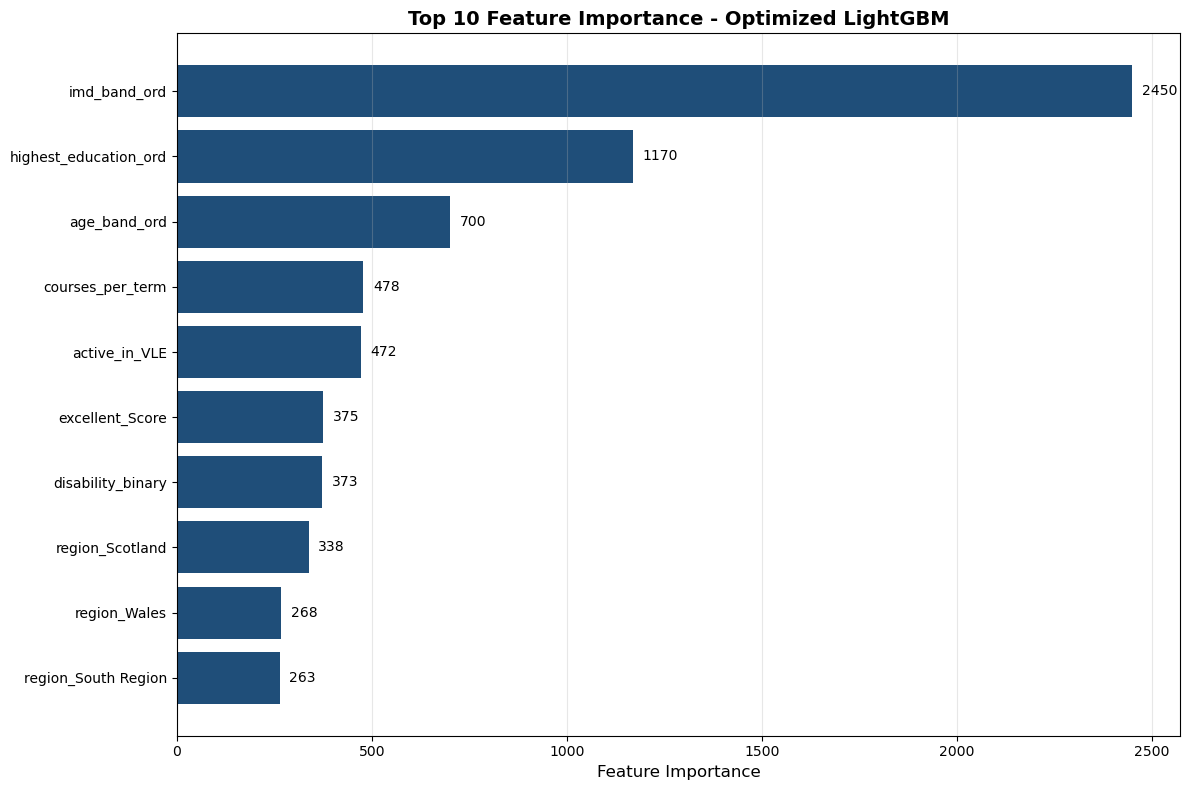

In [17]:
# ================================================================
# 12. FEATURE IMPORTANCE ANALYSIS
# ================================================================

print(f"\n🔍 FEATURE IMPORTANCE ANALYSIS")
print("=" * 60)

# Get feature importance from the best model
feature_importance = best_lgb_model.feature_importances_
feature_names = X_train_lgb.columns

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("📊 TOP 10 MOST IMPORTANT FEATURES:")
print("-" * 50)
for i, row in importance_df.head(10).iterrows():
    print(f"{importance_df.index.get_loc(i)+1:2d}. {row['feature']:25s}: {row['importance']:.4f}")

# Create feature importance plot
plt.figure(figsize=(12, 8))
top_10_features = importance_df.head(10)[::-1]  # Reverse for horizontal bar plot
plt.barh(range(len(top_10_features)), top_10_features['importance'])
plt.yticks(range(len(top_10_features)), top_10_features['feature'])
plt.xlabel('Feature Importance', fontsize=12)
plt.title('Top 10 Feature Importance - Optimized LightGBM', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(top_10_features['importance']):
    plt.text(v + 0.01 * max(top_10_features['importance']), i, f'{v:.0f}', 
             va='center', fontsize=10)

plt.tight_layout()
plt.show()

In [18]:
# ================================================================
# 13. FINAL OPTIMIZED MODEL CODE
# ================================================================

print(f"\n💾 OPTIMIZED MODEL FOR PRODUCTION")
print("=" * 60)

print("✅ Your optimized LightGBM model:")
print()
print("# Copy-paste this code to create your optimized model")
print("optimized_lgb = lgb.LGBMClassifier(")
for param, value in grid_search.best_params_.items():
    if isinstance(value, str):
        print(f"    {param}='{value}',")
    else:
        print(f"    {param}={value},")
print("    random_state=42,")
print("    n_jobs=-1,")
print("    verbose=-1")
print(")")
print()
print("# Train and use the model")
print("optimized_lgb.fit(X_train_lgb, y_train_lgb)")
print("y_pred = optimized_lgb.predict(X_test_lgb)")


💾 OPTIMIZED MODEL FOR PRODUCTION
✅ Your optimized LightGBM model:

# Copy-paste this code to create your optimized model
optimized_lgb = lgb.LGBMClassifier(
    class_weight='balanced',
    colsample_bytree=1.0,
    learning_rate=0.05,
    max_depth=10,
    min_child_samples=20,
    n_estimators=100,
    num_leaves=31,
    subsample=0.8,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

# Train and use the model
optimized_lgb.fit(X_train_lgb, y_train_lgb)
y_pred = optimized_lgb.predict(X_test_lgb)


In [25]:
# ================================================================
# 14. PERFORMANCE SUMMARY
# ================================================================

print(f"\n📈 PERFORMANCE SUMMARY")
print("=" * 60)

print(f"🎯 Optimization Results:")
print(f"   Best CV {recommended_scoring}: {grid_search.best_score_:.4f}")
print(f"   Test set accuracy:           {test_accuracy:.4f}")
print(f"   Test set F1-weighted:        {test_f1_weighted:.4f}")
print(f"   Test set F1-macro:           {test_f1_macro:.4f}")

print(f"\n⚙️  Best Hyperparameters:")
for param, value in grid_search.best_params_.items():
    print(f"   {param}: {value}")

print(f"\n⏱️  Optimization Details:")
print(f"   Total combinations tested: {total_combinations}")
print(f"   Cross-validation folds: {cv_folds}")
print(f"   Runtime: {total_time/60:.1f} minutes")
print(f"   Primary scoring metric: {recommended_scoring}")

print(f"\n🎉 OPTIMIZATION COMPLETE!")
print("Your LightGBM model is now optimized and ready to use!")


📈 PERFORMANCE SUMMARY
🎯 Optimization Results:
   Best CV f1_weighted: 0.5509
   Test set accuracy:           0.5416
   Test set F1-weighted:        0.5470
   Test set F1-macro:           0.4658

⚙️  Best Hyperparameters:
   class_weight: balanced
   colsample_bytree: 1.0
   learning_rate: 0.05
   max_depth: 10
   min_child_samples: 20
   n_estimators: 100
   num_leaves: 31
   subsample: 0.8

⏱️  Optimization Details:
   Total combinations tested: 864
   Cross-validation folds: 5
   Runtime: 108.7 minutes
   Primary scoring metric: f1_weighted

🎉 OPTIMIZATION COMPLETE!
Your LightGBM model is now optimized and ready to use!


In [26]:
# ================================================================
# 15. SAVE PERFORMANCE METRICS
# ================================================================

import os
import joblib
import json
from datetime import datetime

print(f"\n📊 SAVING PERFORMANCE METRICS")
print("=" * 60)

# Create directory structure
base_dir = "../Data"
model_metrics_dir = os.path.join(base_dir, "model_metrics")
models_dir = os.path.join(model_metrics_dir, "models")
metrics_dir = os.path.join(model_metrics_dir, "metrics")
reports_dir = os.path.join(model_metrics_dir, "reports")

# Create directories if they don't exist
os.makedirs(models_dir, exist_ok=True)
os.makedirs(metrics_dir, exist_ok=True)
os.makedirs(reports_dir, exist_ok=True)

model_name = "lightgbm_optimized"

# Save the trained model
model_path = os.path.join(models_dir, f"{model_name}.pkl")
joblib.dump(best_lgb_model, model_path)

print(f"✅ Model saved to: {model_path}")
print(f"📏 Model file size: {os.path.getsize(model_path) / (1024*1024):.2f} MB")

# Helper function to convert numpy types to Python native types
def convert_numpy_types(obj):
    """Convert numpy types to Python native types for JSON serialization"""
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {key: convert_numpy_types(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy_types(item) for item in obj]
    else:
        return obj

# Prepare comprehensive metrics dictionary
model_metrics = {
    "model_info": {
        "model_name": "LightGBM Classifier",
        "optimization_method": "GridSearchCV",
        "primary_scoring_metric": recommended_scoring,
        "total_runtime_minutes": round(total_time/60, 2),
        "feature_scaling": "Not required (tree-based model)"
    },
    "dataset_info": {
        "training_samples": int(X_train_lgb.shape[0]),
        "test_samples": int(X_test_lgb.shape[0]),
        "n_features": int(X_train_lgb.shape[1]),
        "n_classes": int(len(np.unique(y_train_lgb))),
        "class_distribution": {str(k): int(v) for k, v in class_counts.items()}
    },
    "hyperparameters": {
        "best_params": convert_numpy_types(grid_search.best_params_),
        "total_combinations_tested": int(total_combinations),
        "cv_folds": cv_folds
    },
    "cross_validation_results": {
        "best_cv_score": float(grid_search.best_score_),
        "cv_scores_by_metric": {}
    },
    "test_set_performance": {
        "accuracy": float(test_accuracy),
        "f1_weighted": float(test_f1_weighted),
        "f1_macro": float(test_f1_macro)
    },
    "lightgbm_specific_analysis": {
        "feature_importance_top_10": [
            {
                "feature": str(row['feature']),
                "importance": float(row['importance']),
                "rank": int(importance_df.index.get_loc(i) + 1)
            }
            for i, row in importance_df.head(10).iterrows()
        ],
        "class_balance_handling": {
            "method": "class_weight='balanced'" if grid_search.best_params_.get('class_weight') == 'balanced' else "No class balancing",
            "imbalance_ratio": float(imbalance_ratio)
        },
        "tree_parameters": {
            "n_estimators": int(grid_search.best_params_.get('n_estimators', 100)),
            "max_depth": int(grid_search.best_params_.get('max_depth', -1)),
            "num_leaves": int(grid_search.best_params_.get('num_leaves', 31)),
            "learning_rate": float(grid_search.best_params_.get('learning_rate', 0.1))
        }
    }
}

# Add detailed CV results for all metrics
cv_results = grid_search.cv_results_
best_index = grid_search.best_index_

for metric_name in scoring_metrics.keys():
    score_key = f'mean_test_{metric_name}'
    std_key = f'std_test_{metric_name}'
    
    if score_key in cv_results:
        model_metrics["cross_validation_results"]["cv_scores_by_metric"][metric_name] = {
            "mean": float(cv_results[score_key][best_index]),
            "std": float(cv_results[std_key][best_index])
        }

# Convert the entire dictionary to ensure all numpy types are handled
model_metrics = convert_numpy_types(model_metrics)

# Save metrics as JSON
metrics_path = os.path.join(metrics_dir, f"{model_name}_metrics.json")
with open(metrics_path, 'w') as f:
    json.dump(model_metrics, f, indent=2)

print(f"✅ Metrics saved to: {metrics_path}")


📊 SAVING PERFORMANCE METRICS
✅ Model saved to: ../Data\model_metrics\models\lightgbm_optimized.pkl
📏 Model file size: 1.02 MB
✅ Metrics saved to: ../Data\model_metrics\metrics\lightgbm_optimized_metrics.json


In [27]:
# ================================================================
# 16. SAVE CLASSIFICATION REPORT AND CONFUSION MATRIX
# ================================================================

print(f"\n📋 SAVING CLASSIFICATION REPORT")
print("=" * 60)

# Generate detailed classification report
# Get classification report as dictionary
class_report_dict = classification_report(y_test_lgb, y_pred_test, output_dict=True)

# Save classification report
report_path = os.path.join(reports_dir, f"{model_name}_classification_report.json")
with open(report_path, 'w') as f:
    json.dump(class_report_dict, f, indent=2)

print(f"✅ Classification report saved to: {report_path}")

# Save confusion matrix data
confusion_matrix_data = {
    "confusion_matrix": cm.tolist(),
    "class_labels": sorted(np.unique(y_train_lgb).tolist()),
    "model_name": model_name
}

cm_path = os.path.join(metrics_dir, f"{model_name}_confusion_matrix.json")
with open(cm_path, 'w') as f:
    json.dump(confusion_matrix_data, f, indent=2)

print(f"✅ Confusion matrix saved to: {cm_path}")

# Save feature importance as CSV
importance_path = os.path.join(metrics_dir, f"{model_name}_feature_importance.csv")
importance_df.to_csv(importance_path, index=False)
print(f"✅ Feature importance saved to: {importance_path}")


📋 SAVING CLASSIFICATION REPORT
✅ Classification report saved to: ../Data\model_metrics\reports\lightgbm_optimized_classification_report.json
✅ Confusion matrix saved to: ../Data\model_metrics\metrics\lightgbm_optimized_confusion_matrix.json
✅ Feature importance saved to: ../Data\model_metrics\metrics\lightgbm_optimized_feature_importance.csv


In [29]:
# ================================================================
# 17. CREATE MODEL USAGE INSTRUCTIONS
# ================================================================

print(f"\n📖 SAVING MODEL USAGE INSTRUCTIONS")
print("=" * 60)

# Create instructions file
instructions = f"""
LIGHTGBM MODEL USAGE INSTRUCTIONS
=================================

Model Information:
- Model Name: {model_name}
- Model Type: LightGBM Classifier (Optimized)
- Model File: {model_path}

✅ ADVANTAGE: LightGBM does NOT require feature scaling!

LOADING THE MODEL:
-----------------
```python
import joblib
import pandas as pd
import numpy as np

# Load the trained model (no scaler needed!)
model = joblib.load('{model_path}')

# Make predictions directly on raw features
predictions = model.predict(X_new)
prediction_probabilities = model.predict_proba(X_new)
```

BEST HYPERPARAMETERS:
-------------------
{json.dumps(grid_search.best_params_, indent=2)}

PERFORMANCE METRICS:
------------------
- Test Accuracy: {test_accuracy:.4f}
- Test F1-Weighted: {test_f1_weighted:.4f}
- Test F1-Macro: {test_f1_macro:.4f}
- Best CV Score ({recommended_scoring}): {grid_search.best_score_:.4f}

LIGHTGBM-SPECIFIC INSIGHTS:
--------------------------
- Number of trees (n_estimators): {grid_search.best_params_.get('n_estimators', 'N/A')}
- Tree depth (max_depth): {grid_search.best_params_.get('max_depth', 'N/A')}
- Learning rate: {grid_search.best_params_.get('learning_rate', 'N/A')}
- Number of leaves: {grid_search.best_params_.get('num_leaves', 'N/A')}
- Class balancing: {'Applied' if grid_search.best_params_.get('class_weight') == 'balanced' else 'Not applied'}

TOP 5 MOST IMPORTANT FEATURES:
-----------------------------
"""

for i, row in importance_df.head(5).iterrows():
    instructions += f"{importance_df.index.get_loc(i)+1}. {row['feature']}: {row['importance']:.1f}\n"

instructions += f"""

CLASS DISTRIBUTION:
------------------
"""

for class_label, count in class_counts.items():
    percentage = class_percentages[class_label]
    instructions += f"Class {class_label}: {count:,} samples ({percentage:.1f}%)\n"

instructions += f"""

FILES SAVED:
-----------
- Model: {model_path}
- Metrics: {metrics_path}
- Classification Report: {report_path}
- Confusion Matrix: {cm_path}
- Feature Importance: {importance_path}
- Usage Instructions: This file

NOTES:
-----
- This model was optimized using GridSearchCV
- Total combinations tested: {total_combinations}
- Cross-validation: 5-fold
- Optimization runtime: {total_time/60:.1f} minutes
- Primary scoring metric: {recommended_scoring}
- Class imbalance ratio: {imbalance_ratio:.2f}:1

✅ ADVANTAGE: Unlike KNN, LightGBM does NOT require feature scaling!
   You can use the model directly on raw features.

🌳 TREE-BASED MODEL BENEFITS:
   - Handles mixed data types well
   - Built-in feature selection via importance
   - Robust to outliers
   - No need for feature preprocessing
"""

instructions_path = os.path.join(model_metrics_dir, f"{model_name}_USAGE_INSTRUCTIONS.txt")
with open(instructions_path, 'w') as f:
    f.write(instructions)

print(f"✅ Usage instructions saved to: {instructions_path}")

print(f"\n🎉 LIGHTGBM MODEL EXPORT COMPLETE!")
print(f"📂 All files are stored in: {model_metrics_dir}")
print(f"\n💡 To load this model later:")
print(f"   model = joblib.load('{model_path}')")

print("\n🎉 LightGBM MODEL TRAINING AND EVALUATION COMPLETED!")
print("=" * 60)
print(f"📈 Final Test Accuracy: {test_accuracy:.4f}")
print(f"🎯 Best CV Score ({recommended_scoring}): {grid_search.best_score_:.4f}")
print("=" * 60)


📖 SAVING MODEL USAGE INSTRUCTIONS
✅ Usage instructions saved to: ../Data\model_metrics\lightgbm_optimized_USAGE_INSTRUCTIONS.txt

🎉 LIGHTGBM MODEL EXPORT COMPLETE!
📂 All files are stored in: ../Data\model_metrics

💡 To load this model later:
   model = joblib.load('../Data\model_metrics\models\lightgbm_optimized.pkl')

🎉 LightGBM MODEL TRAINING AND EVALUATION COMPLETED!
📈 Final Test Accuracy: 0.5416
🎯 Best CV Score (f1_weighted): 0.5509
